## 합성곱 구현 프로젝트 과제

### 필요한 모듈 임포트

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras
import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)


In [2]:
import time

### cifar10 이미지 로딩

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(type(X_train))
print(X_train.shape)
print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 

print(X_train.shape, X_train.dtype)

170508288/170498071 [==============================] - 3s 0us/step
<class 'numpy.ndarray'>
(50000, 32, 32, 3)
Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32
(50000, 32, 32, 3) uint8


### 이미지 시각화

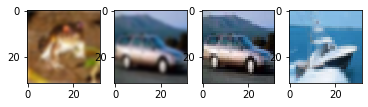

In [4]:
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[4], interpolation="nearest")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[8], interpolation="none")
plt.grid(False)
# plt.subplot(145)
# plt.imshow(X_train[12], interpolation="bicubic")
# plt.grid(False)
# plt.show()

### 이미지 정규화 ( 스케일링 )

In [5]:
print ("mean before normalization:", np.mean(X_train)) 
print ("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape, dtype=float)
newX_test = np.ones(X_test.shape, dtype=float)
print(newX_train.shape)
print(newX_test.shape)
for i in range(3):
    print(type(X_train[:,:,:,i]))
    print(X_train[:,:,:,i].shape)
    mean[i] = np.mean(X_train[:,:,:,i])
    std[i] = np.std(X_train[:,:,:,i])
    
for i in range(3):
    newX_train[:,:,:,i] = X_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = X_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print ("mean after normalization:", np.mean(X_train))
print ("std after normalization:", np.std(X_train))
print(X_train.max())

mean before normalization: 120.70756512369792
std before normalization: 64.1500758911213
(50000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
(50000, 32, 32)
<class 'numpy.ndarray'>
(50000, 32, 32)
<class 'numpy.ndarray'>
(50000, 32, 32)
mean after normalization: 4.91799193961621e-17
std after normalization: 0.9999999999999996
2.126789409516928


### 모델 구현 및 훈련 - 재구현 필요

In [8]:

def get_activation_fn(name):
  if name == 'relu':
    return tf.nn.relu
  elif name == 'softmax':
    return tf.nn.softmax
  elif name == 'sigmoid':
    return tf.math.sigmoid
  elif name == 'tanh':
    return tf.math.tanh
  return None

initializer = tf.initializers.glorot_uniform()

class SimpleConv2D():
  def __init__(self, filters, kernel_size, strides=1, padding='VALID', activation=None, input_shape=None):
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.strides = strides
    self.activate = get_activation_fn(activation)
    if input_shape is not None and len(input_shape) > 2:
      self.channels = input_shape[2]
      self.conv_w = tf.Variable(initializer((kernel_size,
                                              kernel_size,
                                              self.channels,
                                              filters), dtype=tf.dtypes.float64))
      self.conv_b = tf.Variable(np.zeros(filters), dtype=tf.dtypes.float64)
    else:
      self.channels = None
      self.conv_w = None
      self.conv_b = None

  def __call__(self, inputs):
    """
      inputs shape : (batch size, image weight, image height, channels)
    """
    if len(inputs.shape) < 4:
      raise ValueError('SimpleConv2D : invalid the shpae of inputs')
    self.channels = inputs.shape[3]
    if self.conv_w is None:
      self.conv_w =tf.Variable(initializer((self.kernel_size,
                                            self.kernel_size,
                                            self.channels,
                                            self.filters), dtype=tf.dtypes.float64))
    if self.conv_b is None:
      self.conv_b = tf.Variable(np.zeros(self.filters), dtype=tf.dtypes.float64)
    out = tf.nn.conv2d(inputs, self.conv_w, self.strides, self.padding) + self.conv_b
    if self.activate is not None:
      out = self.activate(out)
    return out

  def get_trainable_weights(self):
    return [self.conv_w, self.conv_b]

class SimpleDense():
  def __init__(self, units, activation=None):
    self.w = None
    self.b = None
    self.units = units
    self.activate = get_activation_fn(activation)
  
  def __call__(self, inputs):
    """
      inputs shape : (batch size, features)
    """
    if len(inputs.shape) < 2:
      raise ValueError('SimpleDense : invalid the shpae of inputs')
    if self.w is None:
      self.w = tf.Variable(initializer((inputs.shape[1], self.units), dtype=tf.dtypes.float64))
    if self.b is None:
      self.b = tf.Variable(np.zeros(self.units), dtype=tf.dtypes.float64)
    out = tf.matmul(inputs, self.w) + self.b
    if self.activate is not None:
      out = self.activate(out)
    return out

  def get_trainable_weights(self):
    return [self.w, self.b]

class SimpleFlatten():
  def __call__(self, inputs):
    out = tf.reshape(inputs, [inputs.shape[0], -1])
    return out

  def get_trainable_weights(self):
    return None

class SimpleMaxPooling2D():
  def __init__(self, ksize=2, strides=2, padding='VALID'):
    self.ksize = ksize
    self.strides = strides
    self.padding = padding

  def __call__(self, inputs):
    out = tf.nn.max_pool2d(inputs, self.ksize, self.strides, self.padding)
    return out

  def get_trainable_weights(self):
    return None

class SimpleModel():
  def __init__(self):
    self.layers = []

  def add(self, layer):
    self.layers.append(layer)
  
  def compile(self, learning_rate=1e-4, loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy']):
    self.lr = learning_rate
    self.lossfn = tf.losses.get(loss)
    self.optimizer = tf.optimizers.get({'class_name': optimizer, 'config': {'learning_rate': learning_rate}})
    self.metricfn = []
    for metric_name in metrics:
      self.metricfn.append(tf.keras.metrics.Accuracy(name=metric_name))
    self.losses = []
    self.val_losses = []
    self.batch_size = 1

  def get_trainable_weights(self):
    trainable_weights = []
    for layer in self.layers:
      weights = layer.get_trainable_weights()
      if weights is not None:
        trainable_weights += weights
    return trainable_weights

  def get_accuracy(self, lables, predicts):
    accuracy = []
    for m in self.metricfn:
      p = tf.reshape(tf.math.argmax(predicts, axis=1), lables.shape)
      m.update_state(lables, p)
      accuracy.append(m.result().numpy())
    return accuracy
  
  def get_loss(self, train_data, train_labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    train_dataset = train_dataset.batch(self.batch_size)
    predictions = []
    y_true = []
    losses = []
    for data, labels in train_dataset: #batch...
      pred, loss = self.call(data, labels)
      losses.append(loss)
      predictions.append(pred)
      y_true.append(labels)
    predictions = tf.concat(predictions, 0)
    y_true = tf.concat(y_true, 0)
    accuracy = self.get_accuracy(y_true, predictions)
    return tf.reduce_mean(losses), accuracy
    
  def call(self, data, labels):
    predictions = None
    loss = None
    for layer in self.layers:
      if predictions is None:
        predictions = data
      predictions = layer(predictions)
    loss = tf.reduce_mean(self.lossfn(labels, predictions))
    return predictions, loss

  def fit(self, train_data, train_labels, batch_size=512, epochs=10, valid_data=None, valid_labels=None):
    self.batch_size = batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    if valid_data != None and valid_labels != None:
      valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
    train_dataset = train_dataset.shuffle(len(train_data)*10).batch(batch_size)
    print_steps = len(train_dataset) // 20
    for i in range(epochs):
      step = 0
      print('Epoch {}/{}'.format(i+1, epochs))
      start_time = time.time()
      print("[=", end="")
      for data, labels in train_dataset: #batch...
        step = step + 1
        if step % print_steps == 0:
          print("=", end="")
        with tf.GradientTape() as tape:
          pred, loss = self.call(data, labels)
        trainable_weights = self.get_trainable_weights()
        gradients = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))
        self.losses.append(loss.numpy())
      print("]", end="")
      if valid_data != None and valid_labels != None:
        _, val_loss = self.call(valid_data, valid_labels)
        self.val_losses.append(val_loss.numpy())
      duration = time.time() - start_time
      result = self.evaluate(train_data, train_labels)
      print(" {} sec/step - loss : {} - accuracy : {}".format(duration, result['loss'], result['accuracy']))
    return self.losses
  
  def evaluate(self, test_data, test_labels):
    loss, accuracy = self.get_loss(test_data, test_labels)
    #print('loss : {} - accuracy: {}'.format(loss, accuracy))
    return {'loss':loss.numpy(), 'accuracy':accuracy}

In [9]:
num_classes = 10     
batchSize = 128                   #-- Training Batch Size
num_epochs = 20                   #-- Number of epochs for training   
learningRate= 0.001                #-- Learning rate for the network
img_rows = 32                     #-- input image dimensions
img_cols = 32 
img_ch=3

model = SimpleModel()
model.add(SimpleConv2D(filters=64, kernel_size=3, activation='relu', padding='SAME', input_shape=(img_rows, img_cols, img_ch)))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleFlatten())
model.add(SimpleDense(512, activation='relu'))
model.add(SimpleDense(512, activation='relu'))
model.add(SimpleDense(num_classes, activation='softmax'))
model.compile(learning_rate=learningRate, loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, batch_size=batchSize, epochs=num_epochs)

Epoch 1/20
[=====================] 55.537132024765015 sec/step - loss : 0.9972834522502708 - accuracy : [0.64586]
Epoch 2/20
[=====================] 27.959032773971558 sec/step - loss : 0.7463585413563769 - accuracy : [0.69235]
Epoch 3/20
[=====================] 26.48104190826416 sec/step - loss : 0.5655067898151744 - accuracy : [0.73112667]
Epoch 4/20
[=====================] 26.41488552093506 sec/step - loss : 0.4710973036508254 - accuracy : [0.757275]
Epoch 5/20
[=====================] 26.292039155960083 sec/step - loss : 0.31282846972180595 - accuracy : [0.78422]
Epoch 6/20
[=====================] 26.21582579612732 sec/step - loss : 0.29003556342322073 - accuracy : [0.80426]
Epoch 7/20
[=====================] 26.160837650299072 sec/step - loss : 0.19356710879751152 - accuracy : [0.8230714]
Epoch 8/20
[=====================] 26.096681356430054 sec/step - loss : 0.18004494856163655 - accuracy : [0.837565]
Epoch 9/20
[=====================] 26.010551929473877 sec/step - loss : 0.168868

In [11]:
result = model.evaluate(X_test, y_test)
print(result)

{'loss': 1.3543518964428904, 'accuracy': [0.91644156]}


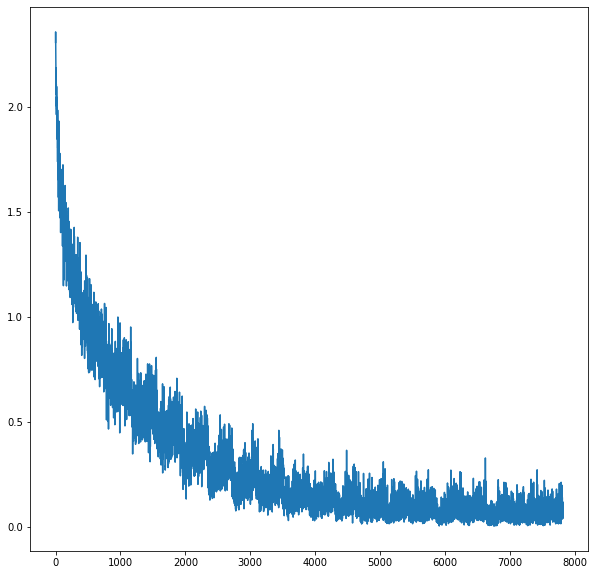

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(history)
plt.show()